In [1]:
from functools import partial
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

In [2]:
######### Defining Continuous Wavelet Transform ######

def get_bc(cycles, freq, k_sd=5):
  return cycles/(k_sd * freq)

def cxmorelet(freq, cycles, sampling_freq):
    t = jnp.linspace(-1, 1, sampling_freq*2)

    bc = get_bc(cycles, freq)
    norm = 1/(bc * jnp.sqrt(2*jnp.pi))
    gauss = jnp.exp(-t**2/(2*bc**2))
    sine = jnp.exp(1j*2*jnp.pi*freq*t)

    wavelet = norm * gauss * sine
    return wavelet / jnp.sum(jnp.abs(wavelet))

@partial(jax.jit, static_argnums=3)
@partial(jax.vmap, in_axes=(None, 0, None, None))
def wavelet_transform(signal, freq, cycles, sampling_freq):    
    wavelet = cxmorelet(freq, cycles, sampling_freq)
    return jax.scipy.signal.convolve(signal, wavelet, mode="same")

In [3]:
######### Defining Superlet Transform ######

@partial(jax.jit, static_argnums=3)
@partial(jax.vmap, in_axes=(None, None, 0, None))
def superlet_transform_helper(signal, freqs, order, sampling_freq):
    return wavelet_transform(signal, freqs, order, sampling_freq) * jnp.sqrt(2)

def order_to_cycles(base_cycle, max_order, mode):
    if mode == "add":
        return jnp.arange(0, max_order) + base_cycle
    elif mode == "mul":
        return jnp.arange(1, max_order+1) * base_cycle
    else: raise ValueError("mode should be one of \"mul\" or \"add\"")

def get_order(f, f_min: int, f_max: int, o_min: int, o_max: int):
    return o_min + round((o_max - o_min) * (f - f_min) / (f_max - f_min))

@partial(jax.vmap, in_axes=(0, None))
def get_mask(order, max_order):
    return jnp.arange(1, max_order+1) > order

@jax.jit
def norm_geomean(X, root_pows, eps):
    X = jnp.log(X + eps).sum(axis=0)

    return jnp.exp(X / jnp.array(root_pows).reshape(-1, 1))

def adaptive_superlet_transform(signal, freqs, sampling_freq: int, base_cycle: int, min_order: int, max_order: int, eps=1e-12, mode="mul"):
    """Computes the adaptive superlet transform of the provided signal

    Args:
        signal (jnp.ndarray): 1D array containing the signal data
        freqs (jnp.ndarray): 1D sorted array containing the frequencies to compute the wavelets at
        sampling_freq (int): Sampling frequency of the signal 

        base_cycle (int): The number of cycles corresponding to order=1
        min_order (int): The minimum upper limit of orders to be used for a frequency in the adaptive superlet.
        max_order (int): The maximum upper limit of orders to be used for a frequency in the adaptive superlet.
        
        eps (float, optional): Epsilon value to be used for numerical stability in the geometric mean. Defaults to 1e-12.
        mode (str, optional): "add" or "mul", corresponding to the use of additive or multiplicative adaptive superlets. Defaults to "mul".

    Returns:
        jnp.ndarray: 2D array (Frequency x Time) representing the computed scalogram
    """
    cycles = order_to_cycles(base_cycle, max_order, mode)
    orders = get_order(freqs, min(freqs), max(freqs), min_order, max_order)
    mask = get_mask(orders, max_order)

    out = superlet_transform_helper(signal, freqs, cycles, sampling_freq)
    out=out.at[mask.T].set(1)
    return norm_geomean(out, orders, eps)

# Test Signal by Moca et al.

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


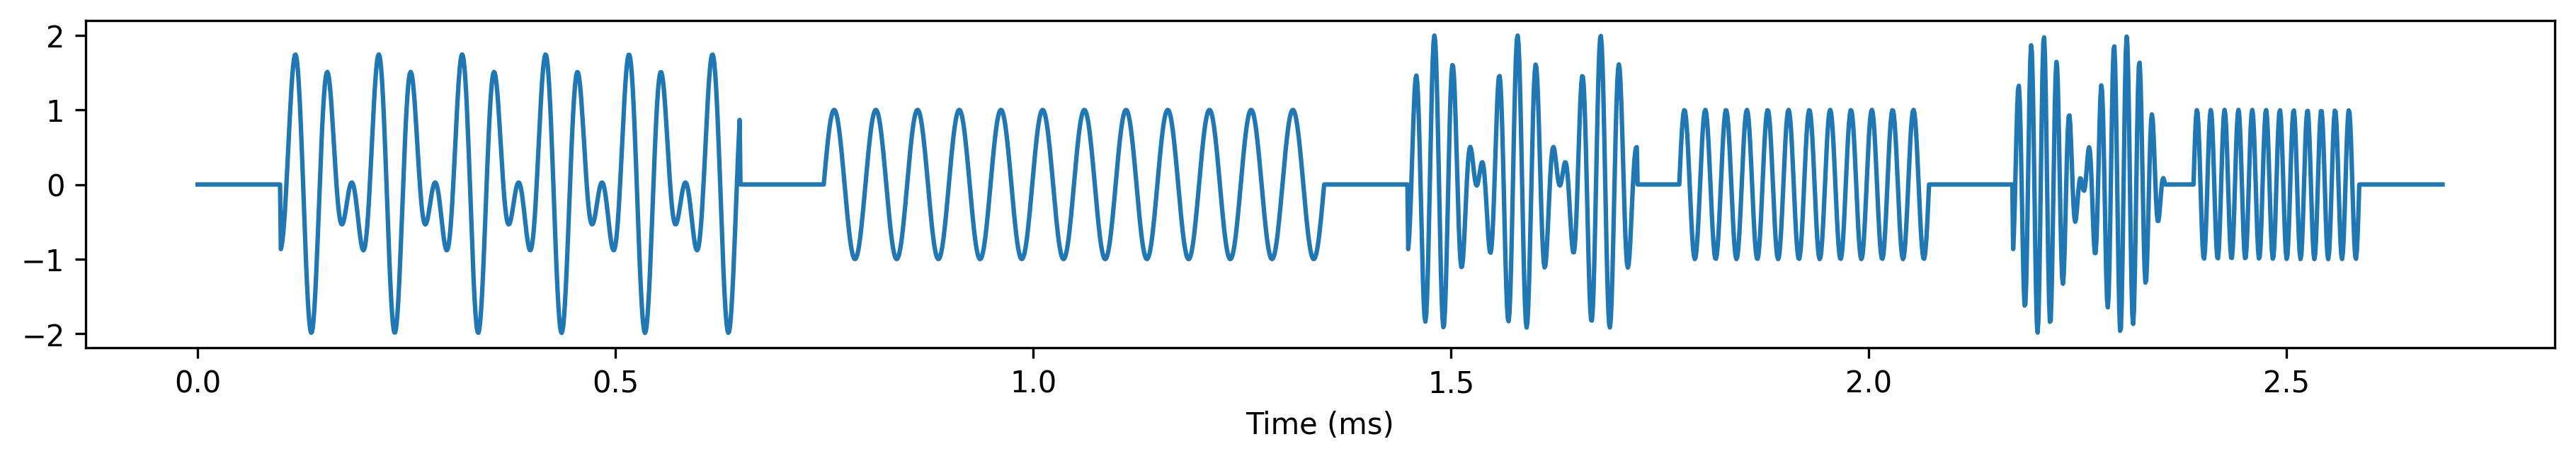

In [4]:
############# Generate Test signal ############

fs = 1024
burst_freqs = [20, 40, 60]
f_shift = 10
n_cycles = 11
n_neighb_cycles = 12

ys = []

# create a 0.1s blank signal to start
ys.append(jnp.zeros(int(fs*0.1)))

for f in burst_freqs:
  # frequency contaminated signal
  t = 1/f * n_cycles
  x = jnp.linspace(0, t, int(t * fs))
  y = jnp.sin(2*jnp.pi*f*x) + jnp.sin(2*jnp.pi*(f+f_shift)*x - jnp.pi/1.5)
  ys.append(y)

  # time contaminated signal, 2 cycles later
  ys.append(jnp.zeros(int(fs*(1/f)*2)))
  
  t2 = 1/f * n_neighb_cycles
  x = jnp.linspace(0, t2, int(t2 * fs))
  y = jnp.sin(2*jnp.pi*f*x)
  ys.append(y)

  # space between bursts of 0.1s
  ys.append(jnp.zeros(int(fs*0.1)))

signal = jnp.concatenate(ys)

fig, ax = plt.subplots(figsize=(15, 2), dpi=300)
ax.set_xlabel("Time (ms)")
ax.plot(jnp.linspace(0, len(signal)/fs, len(signal)), signal)

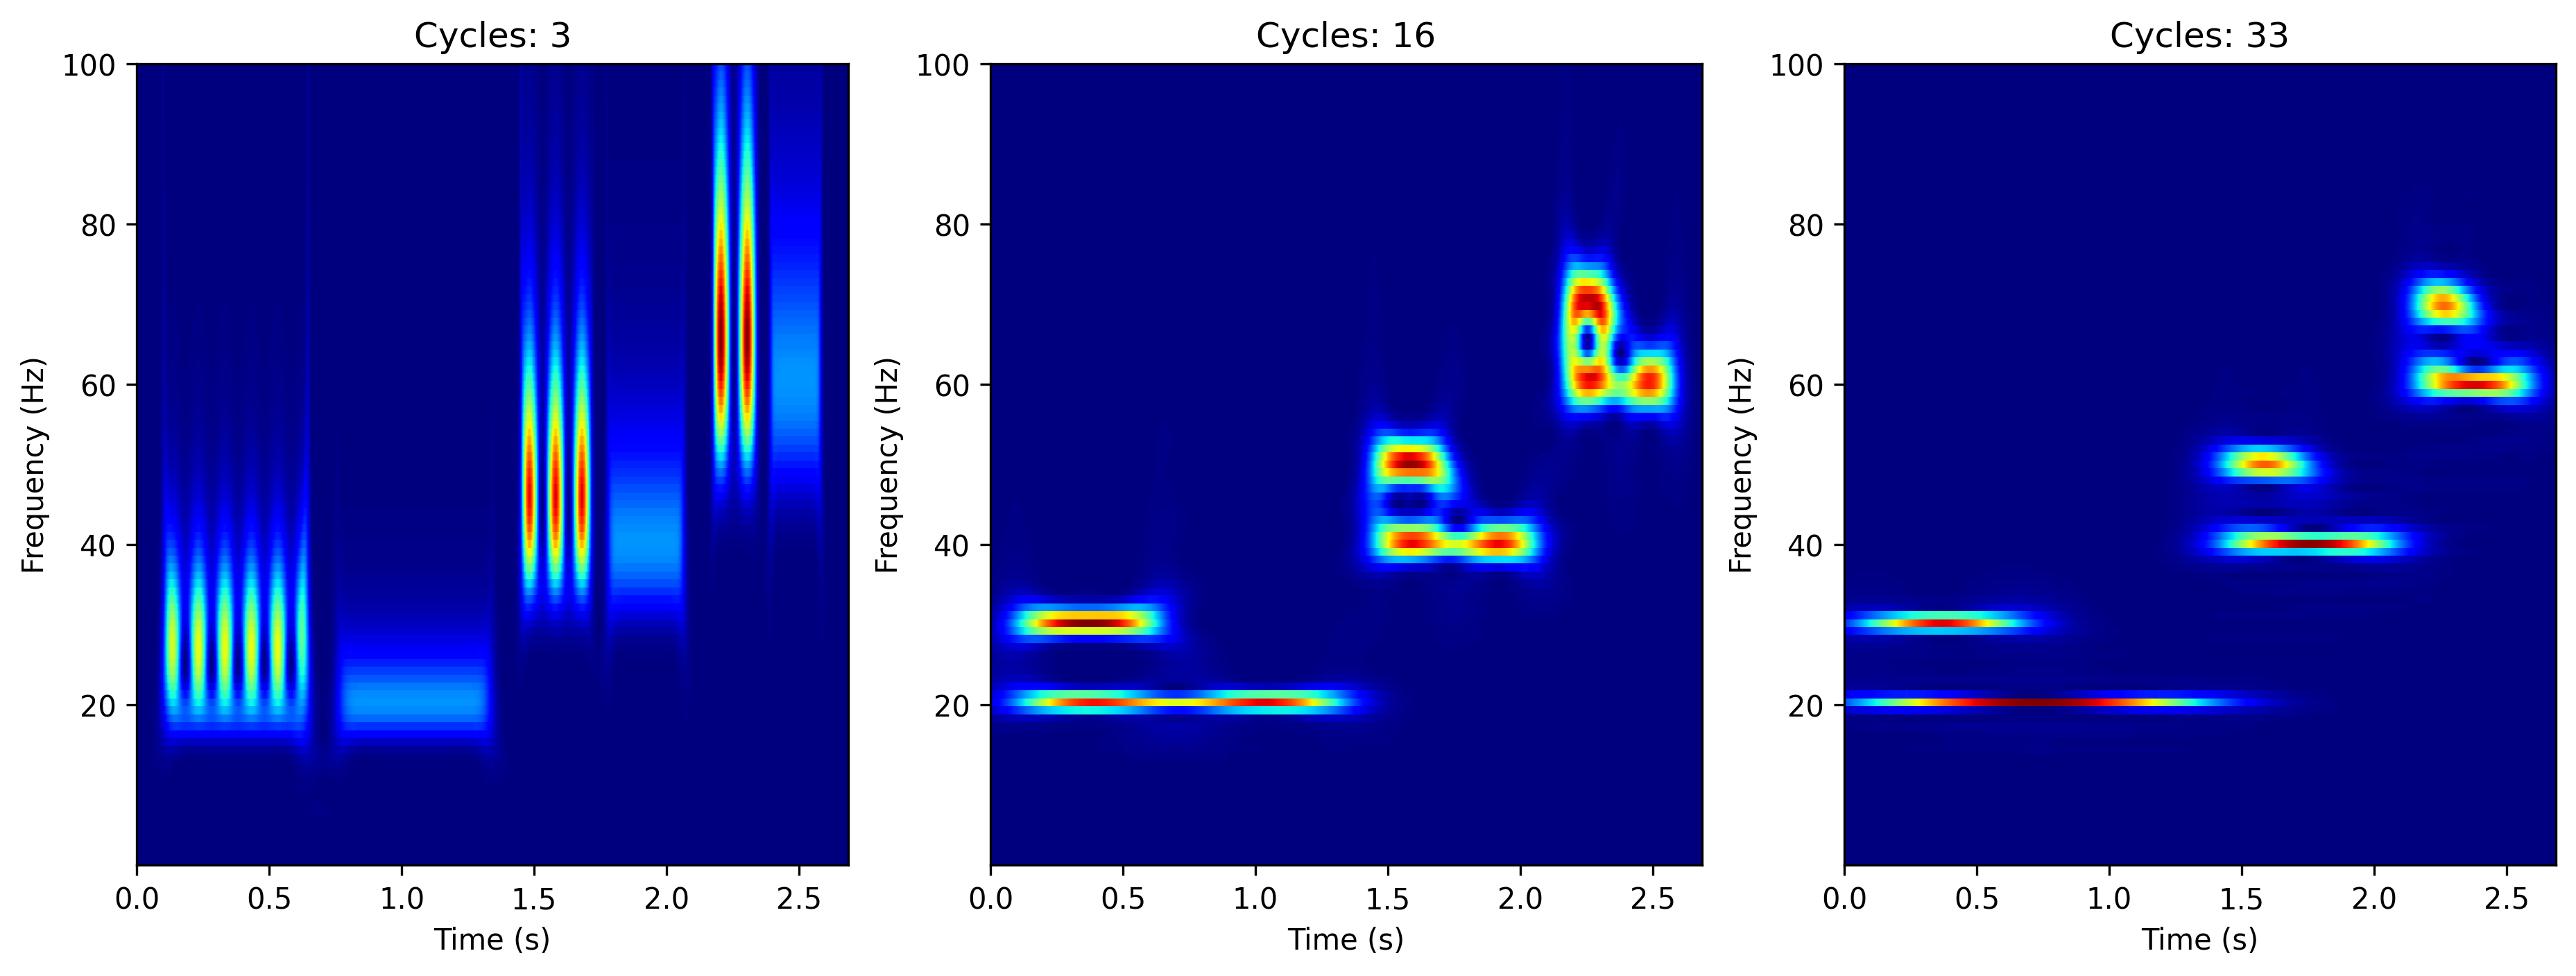

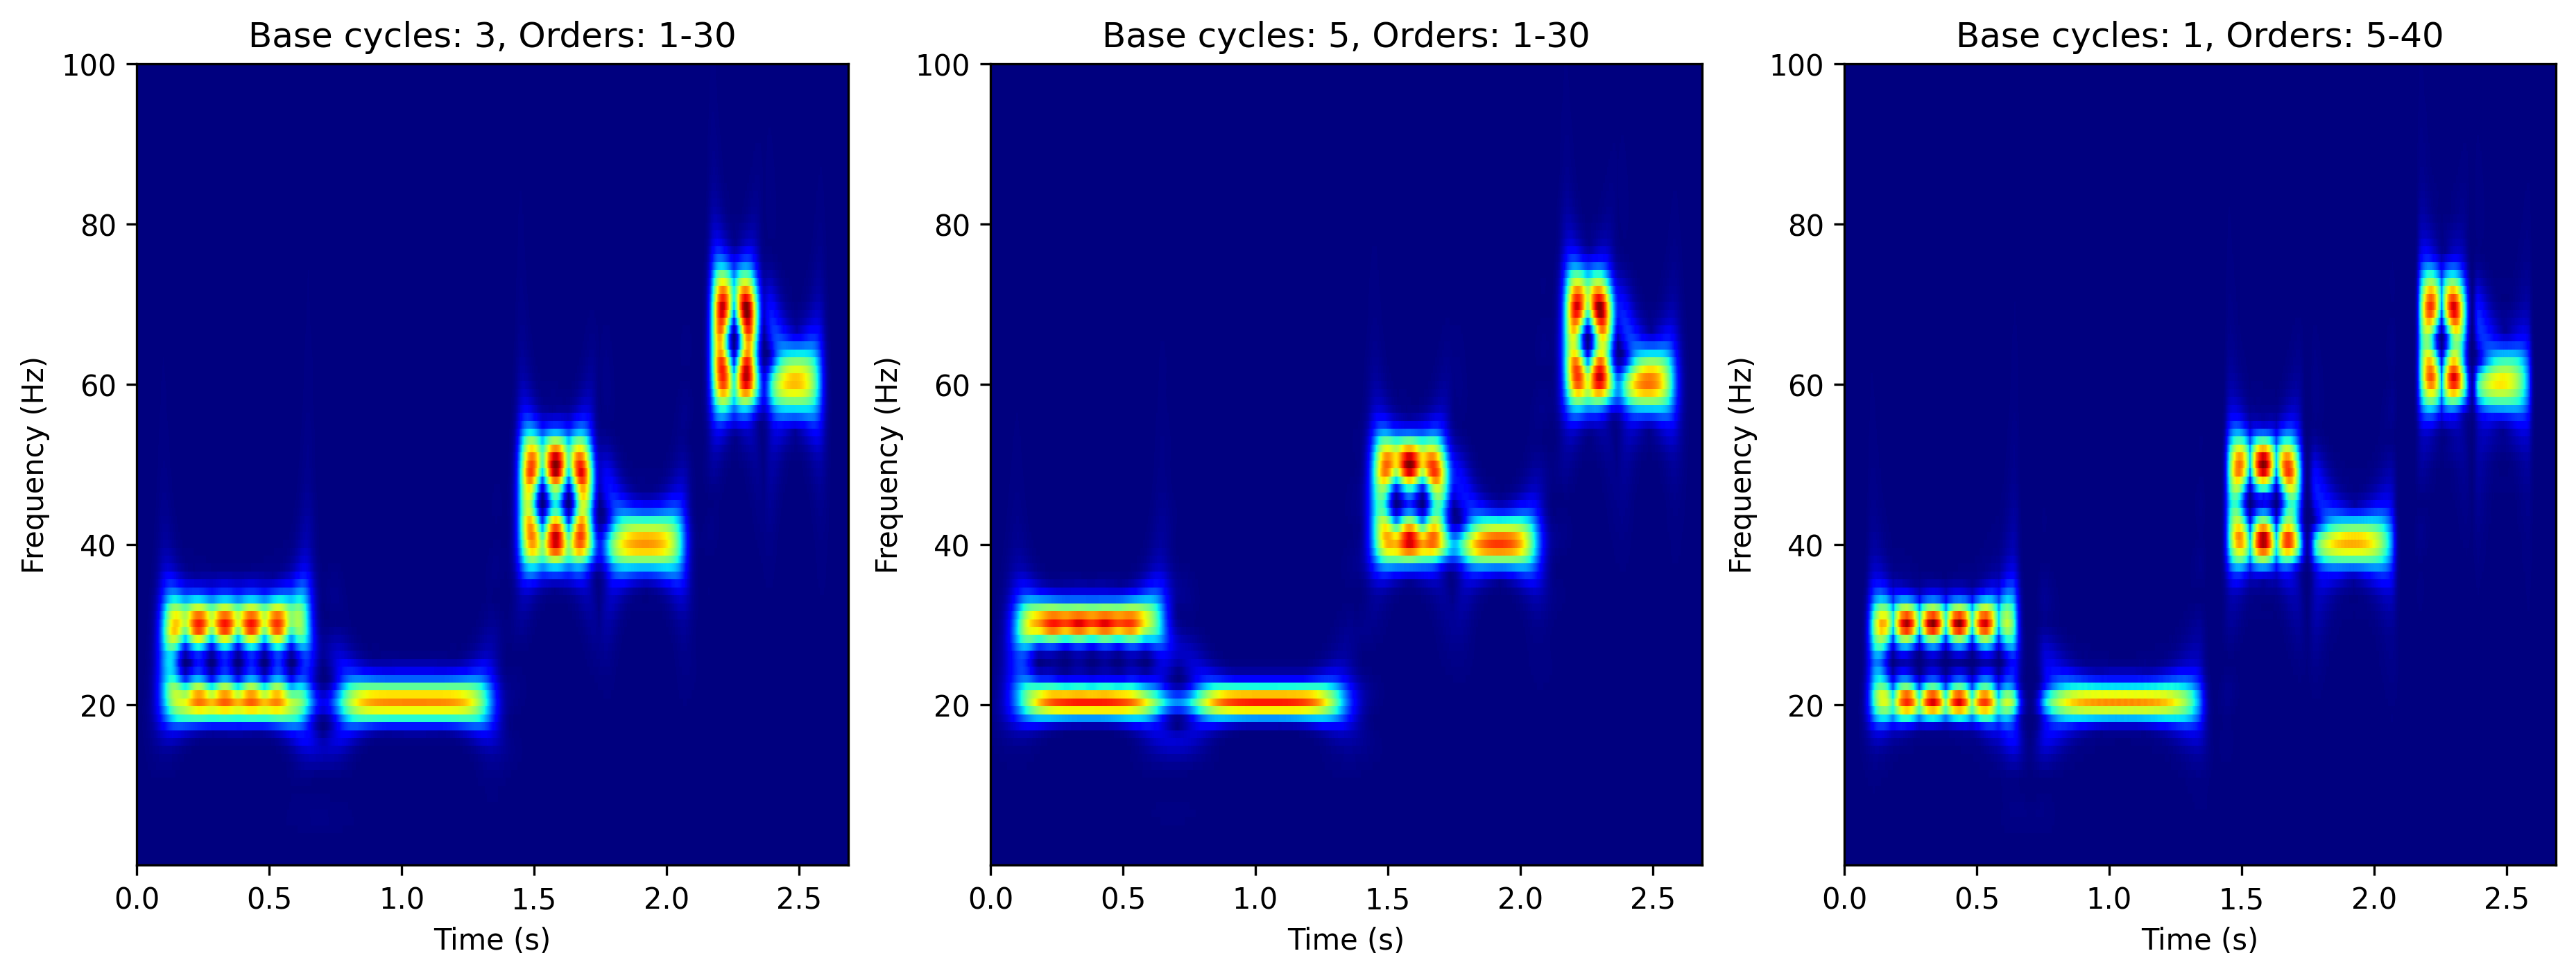

In [5]:
freqs = jnp.linspace(0.01, 100, 101)
fig, ax = plt.subplots(ncols=3, figsize=(15, 5), dpi=300)

for i, c in enumerate([3, 16, 33]):
    scalogram = wavelet_transform(signal, freqs, c, fs)
    ax[i].imshow(jnp.abs(scalogram)**2, aspect='auto', cmap="jet", interpolation="none", origin="lower", extent=[0, len(signal)/fs, freqs[0], freqs[-1]])
    ax[i].set_title(f"Cycles: {c}")
    ax[i].set_xlabel("Time (s)")
    ax[i].set_ylabel("Frequency (Hz)")
    
fig, ax = plt.subplots(ncols=3, figsize=(15, 5), dpi=300)

for (i, (base_cycle, min_order, max_order)) in enumerate(zip([3, 5, 1], [1, 1, 5], [30, 30, 40])):
    scalogram = adaptive_superlet_transform(signal, freqs, sampling_freq=fs, 
                                        base_cycle=base_cycle, min_order=min_order, max_order=max_order, mode="add")
    ax[i].imshow(jnp.abs(scalogram)**2, aspect='auto', cmap="jet", interpolation="none", origin="lower", extent=[0, len(signal)/fs, freqs[0], freqs[-1]])
    ax[i].set_title(f"Base cycles: {base_cycle}, Orders: {min_order}-{max_order}")
    ax[i].set_xlabel("Time (s)")
    ax[i].set_ylabel("Frequency (Hz)")

# Test signal - chirp

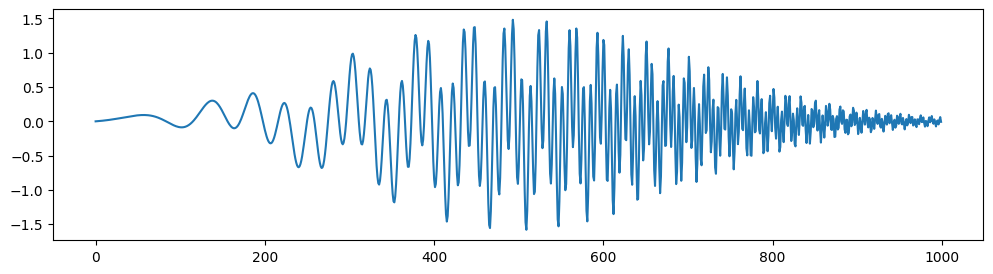

In [6]:
############# Generate Chirp signal ############

def gaussian(x, x0, sigma):
    return np.exp(-np.power((x - x0) / sigma, 2.0) / 2.0)

def make_chirp(t, t0, a):
    frequency = (a * (t + t0)) ** 2
    chirp = np.sin(2 * np.pi * frequency * t)
    return chirp, frequency

time = np.linspace(0, 1, 1000)
chirp1, frequency1 = make_chirp(time, 0.2, 9)
chirp2, frequency2 = make_chirp(time, 0.1, 5)
chirp = chirp1 + 0.6 * chirp2
chirp *= gaussian(time, 0.5, 0.2)
fig = plt.figure(figsize=(12,3), dpi=100)
plt.plot(chirp)
plt.show()

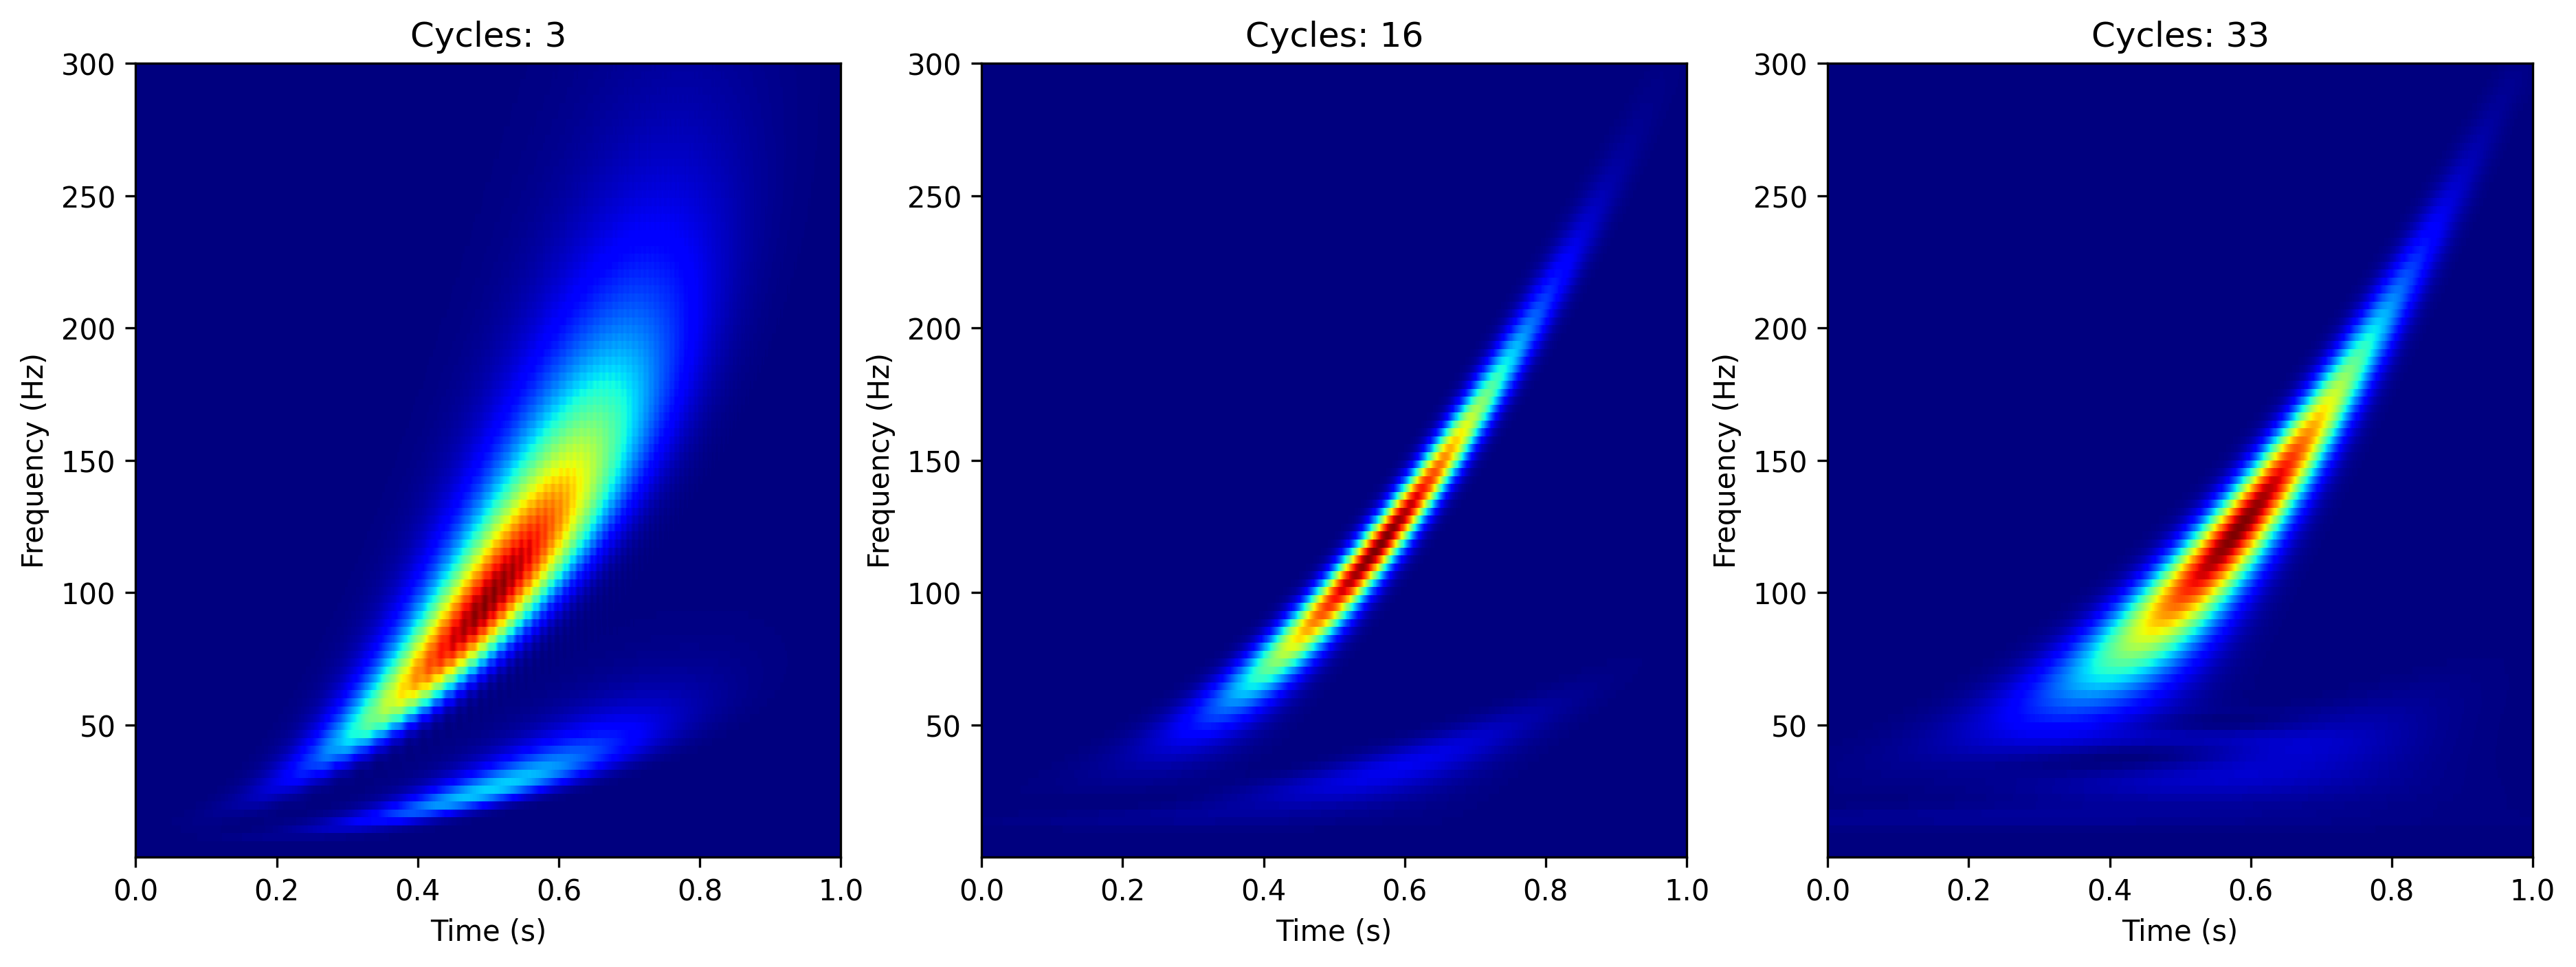

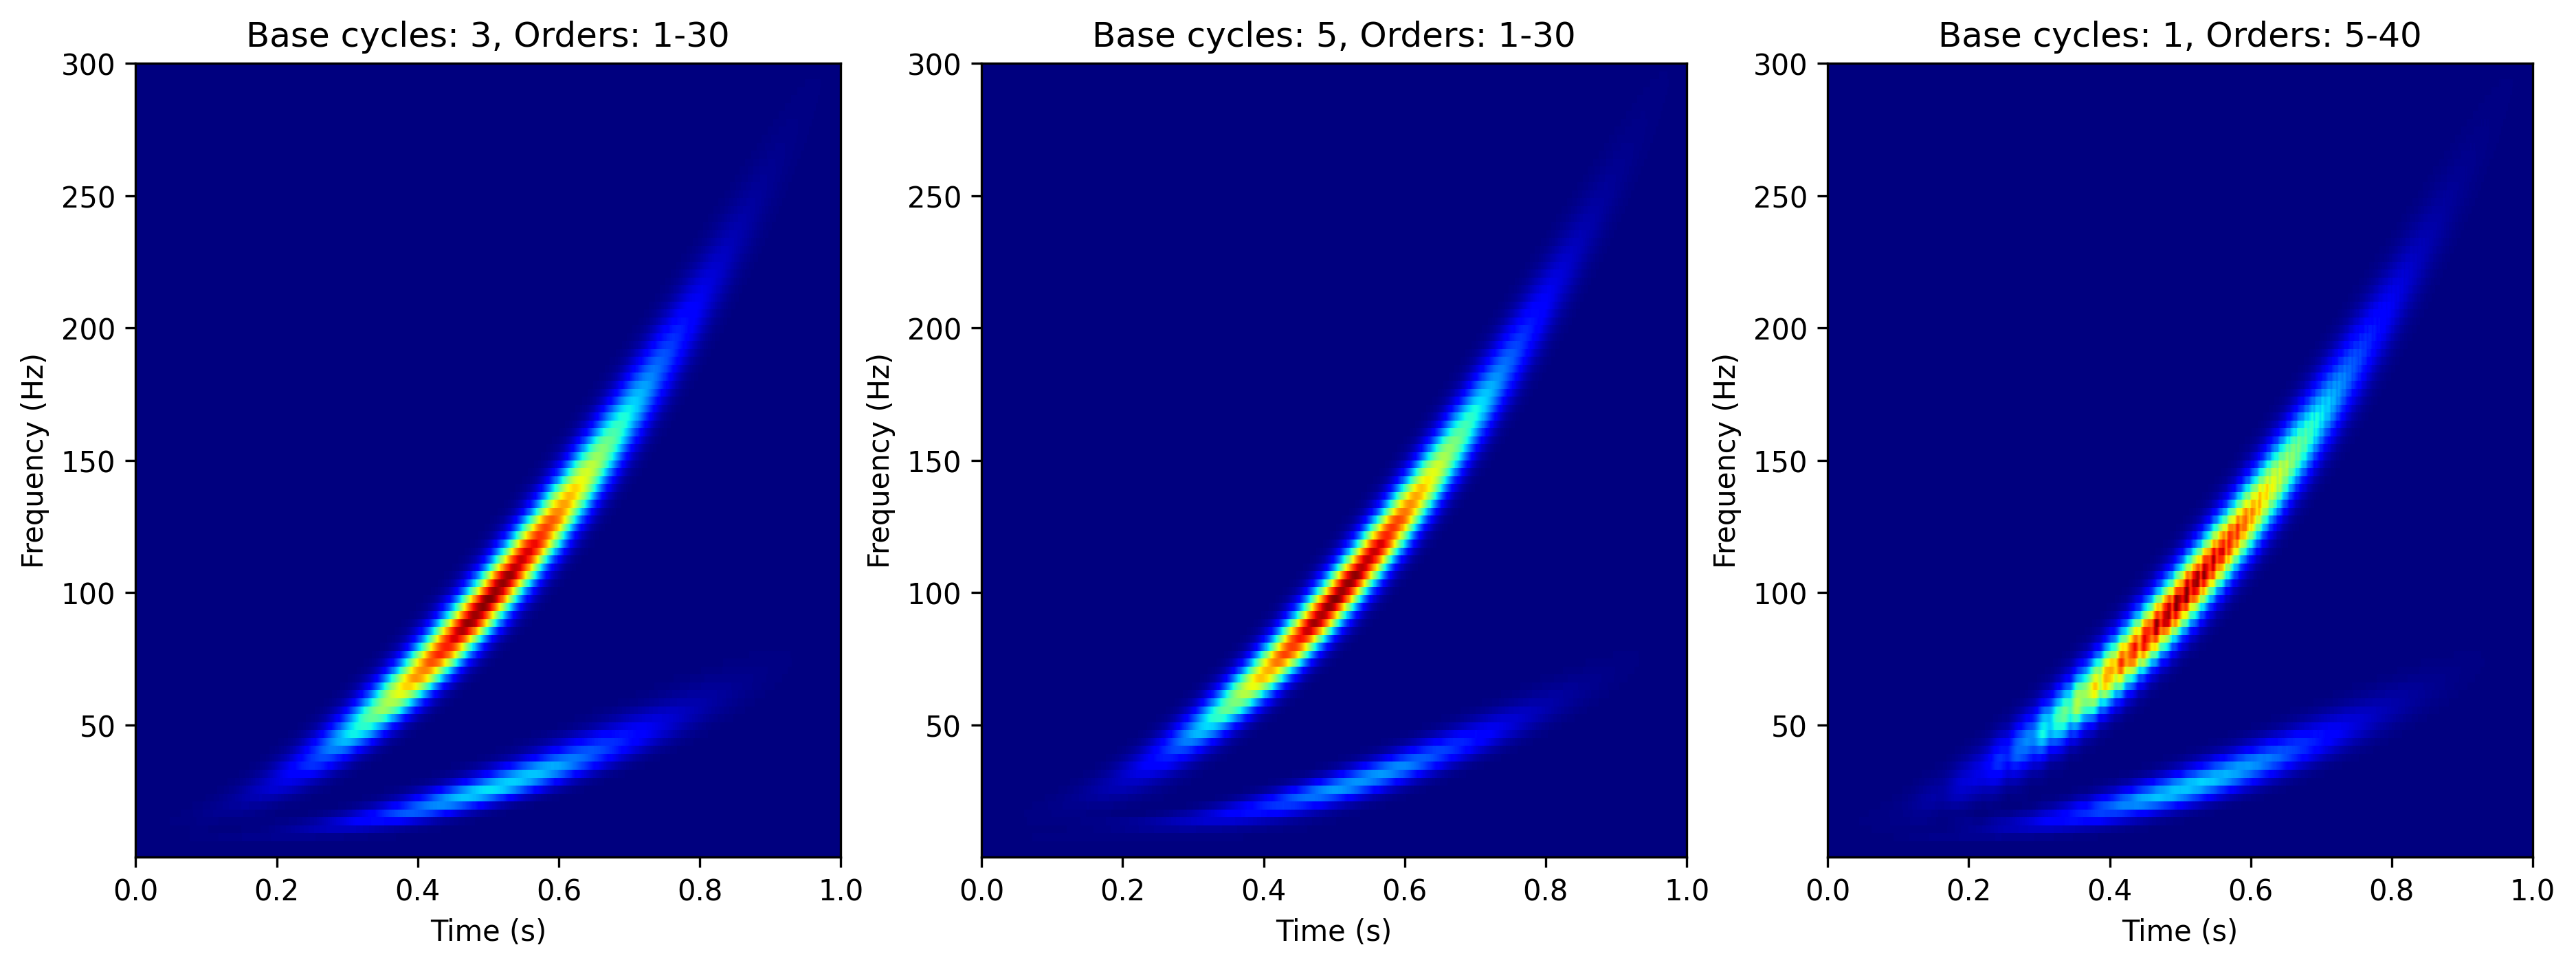

In [7]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5), dpi=300)
freqs = jnp.linspace(0.01, 300, 100)
fs=1000
w=chirp
for i, c in enumerate([3, 16, 33]):
    scalogram = wavelet_transform(w, freqs, c, fs)
    ax[i].imshow(jnp.abs(scalogram)**2, aspect='auto', cmap="jet", interpolation="none", origin="lower", extent=[0, len(w)/fs, freqs[0], freqs[-1]])
    ax[i].set_title(f"Cycles: {c}")
    ax[i].set_xlabel("Time (s)")
    ax[i].set_ylabel("Frequency (Hz)")
    
fig, ax = plt.subplots(ncols=3, figsize=(15, 5), dpi=300)

for (i, (base_cycle, min_order, max_order)) in enumerate(zip([3, 5, 1], [1, 1, 5], [30, 30, 40])):
    scalogram = adaptive_superlet_transform(w, freqs, sampling_freq=fs, 
                                        base_cycle=base_cycle, min_order=min_order, max_order=max_order, mode="add")
    ax[i].imshow(jnp.abs(scalogram)**2, aspect='auto', cmap="jet", interpolation="none", origin="lower", extent=[0, len(w)/fs, freqs[0], freqs[-1]])
    ax[i].set_title(f"Base cycles: {base_cycle}, Orders: {min_order}-{max_order}")
    ax[i].set_xlabel("Time (s)")
    ax[i].set_ylabel("Frequency (Hz)")

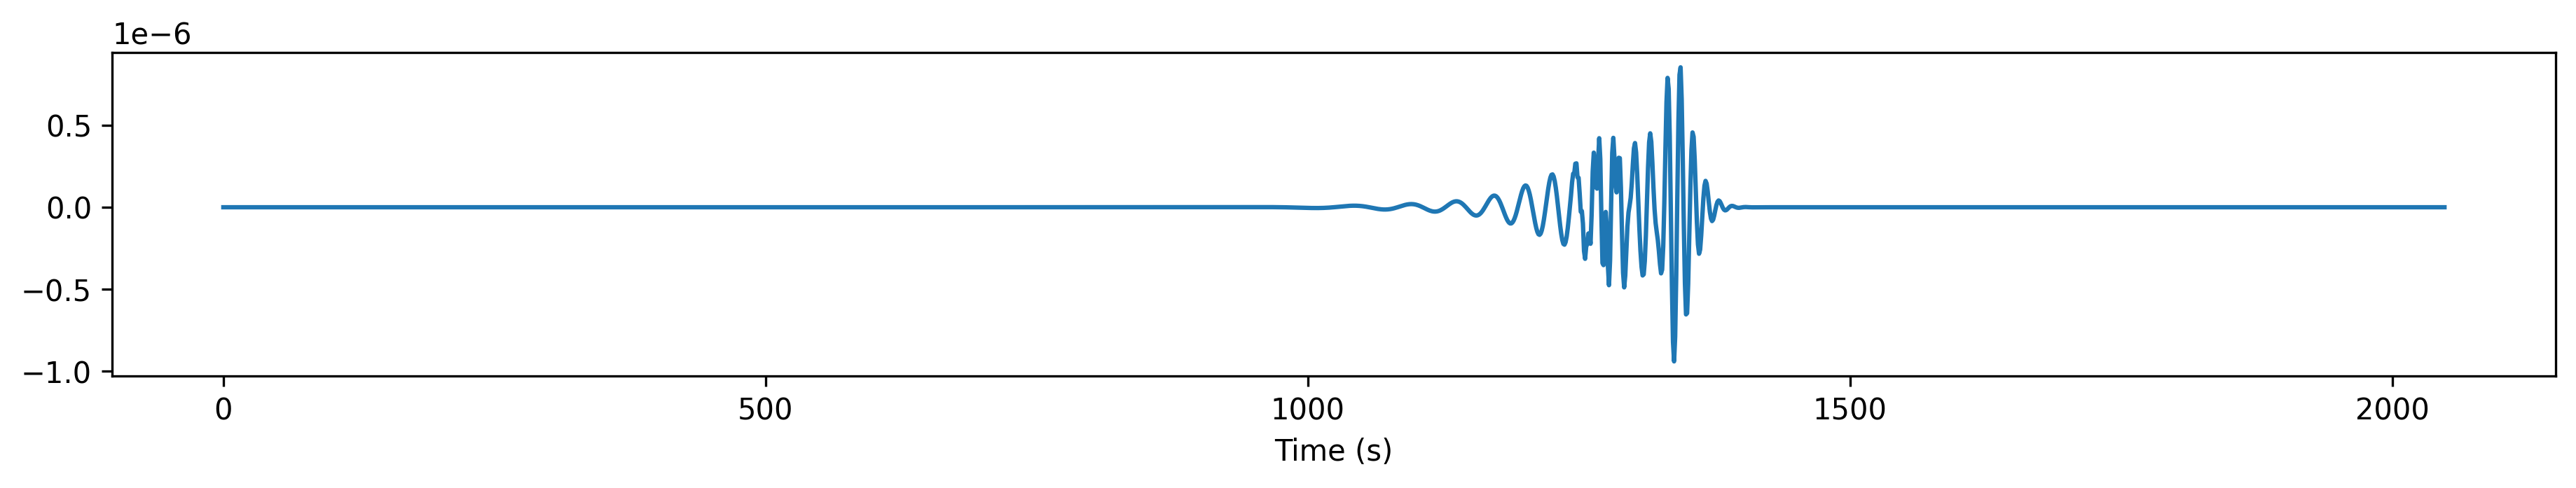

In [8]:
############# Plot synthetic seismogram ############

from obspy.core import read

s=read(r"C:\Users\priya\Downloads\exp\syn4\B00101Z00.sac")

fs = 1
header=s[0].stats
distance=header.sac['dist']
signal=s[0].data
fig, ax = plt.subplots(figsize=(15, 2), dpi=300)
ax.set_xlabel("Time (s)")
ax.plot(jnp.linspace(0, len(signal)/fs, len(signal)), signal)

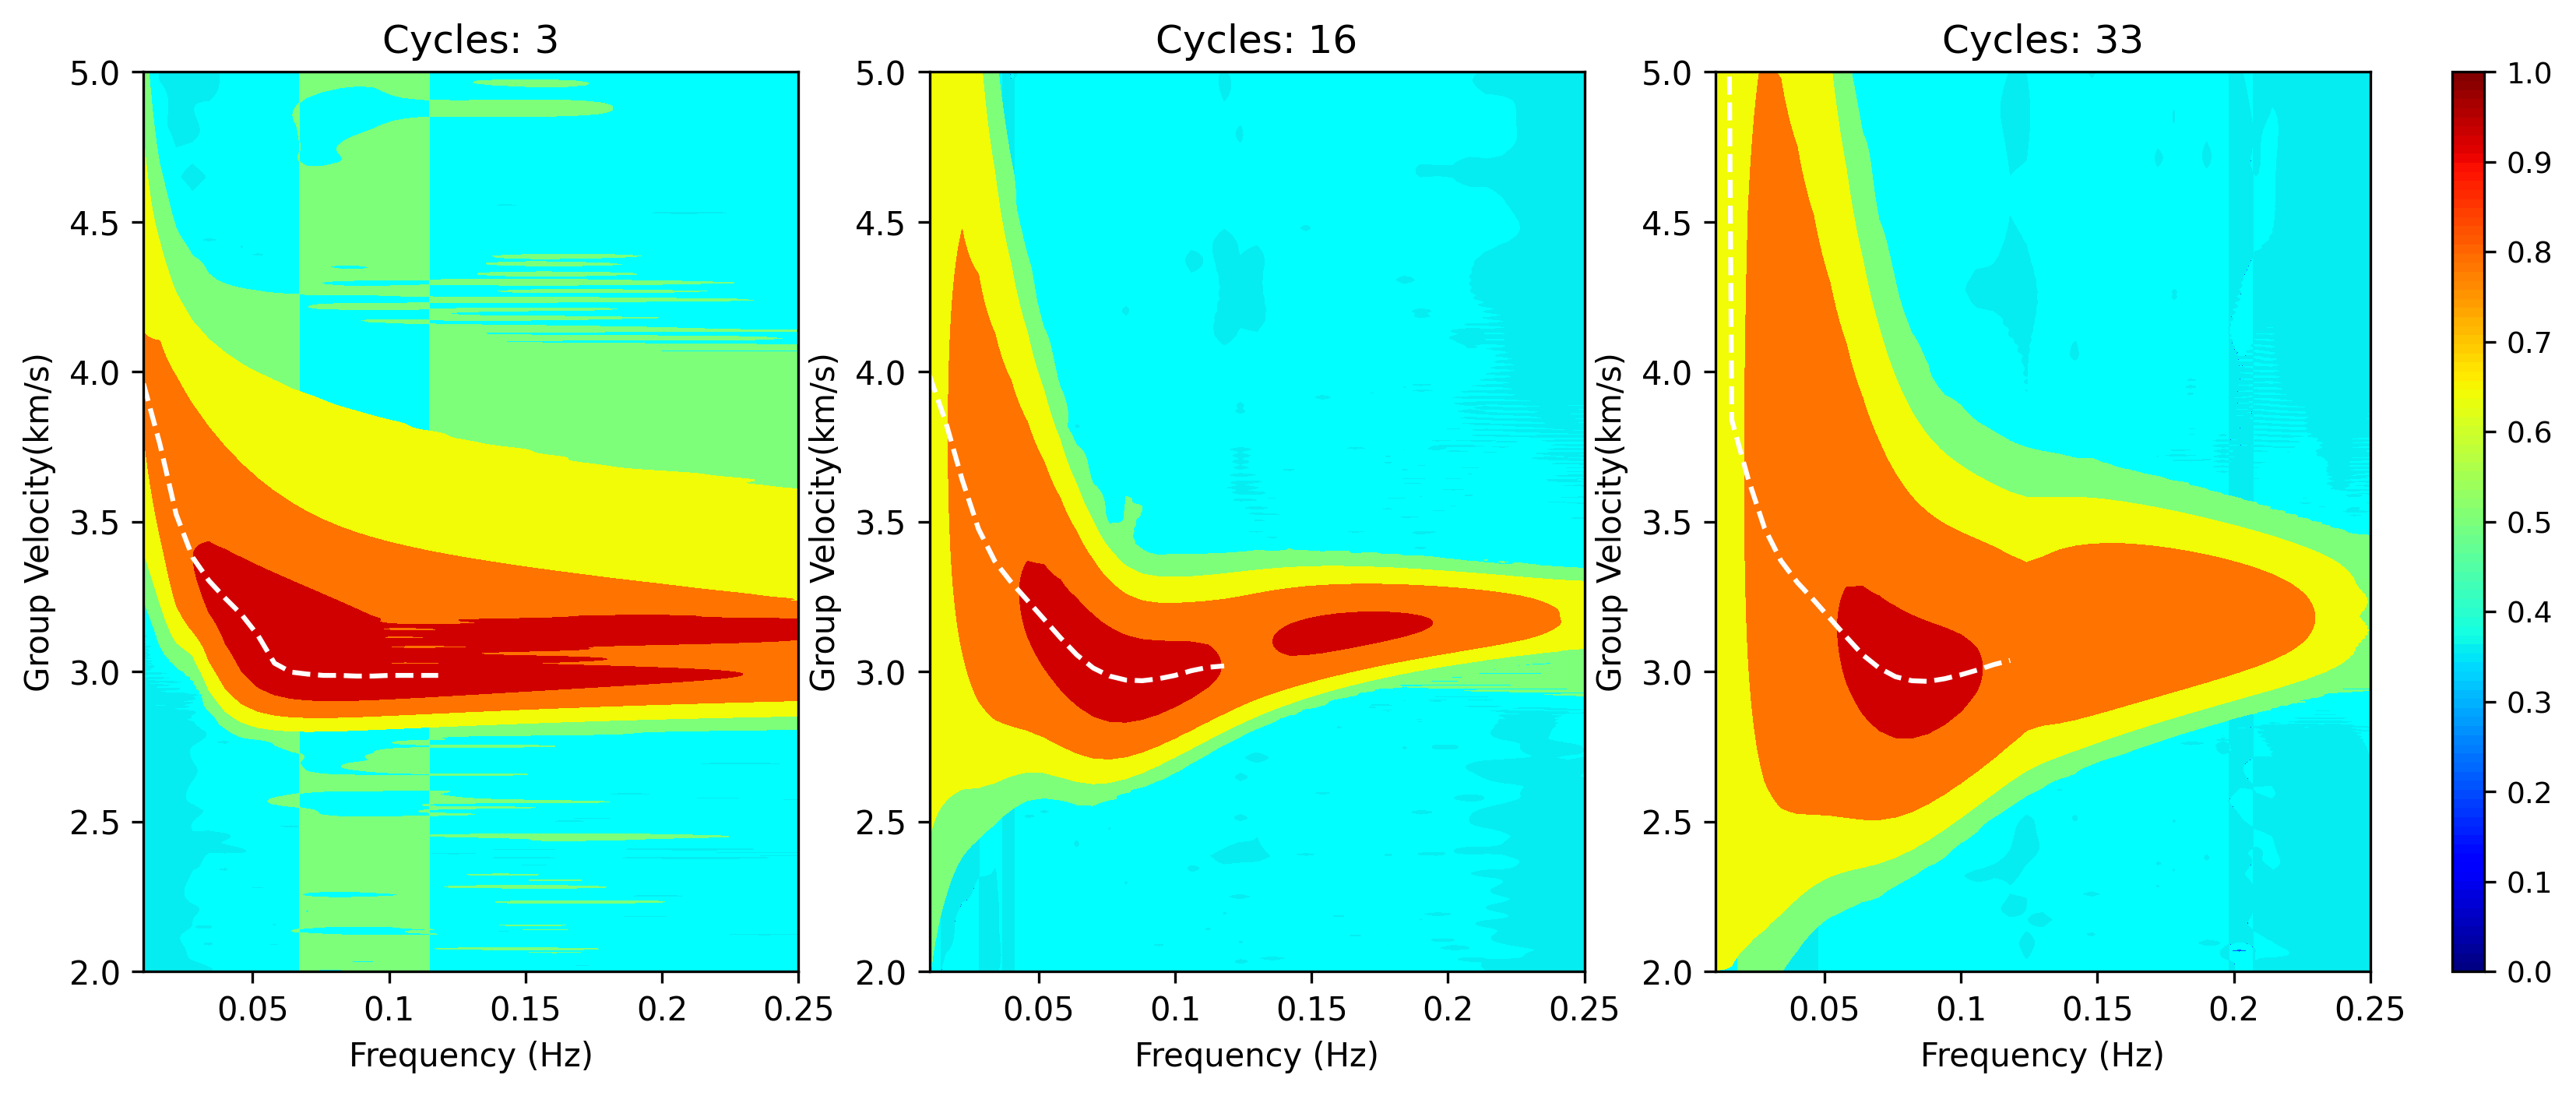

In [9]:
####### Code to plot dispersion image of the synthetic seismogram (add discretization to improve quality of dispersion images)##
velocity=np.zeros(len(signal))
freqs = jnp.linspace(10, 250, 41)
for k in range(len(signal), 0, -1):
    velocity[len(signal)-k-1]=(distance)/k

fig, ax = plt.subplots(ncols=3, figsize=(15, 5), dpi=300)

for i, c in enumerate([3, 16, 33]):
    scalogram = wavelet_transform(signal, freqs, c, fs*1000)
    arr=[]
    points=np.zeros(len(freqs))
    for n in range (0,len(freqs)):
        amplitude=20*(np.log10(np.abs(scalogram[n])))
        
        ######### To discretize dispersion image ######## 
#         print(np.max(amplitude), np.min(amplitude))
#         for j in range(len(amplitude)):
# #         print(j)
#             for k in range(int(np.max(amplitude)), int(np.min(amplitude)), -10):
#                 if k > amplitude[j] > k-10:
#                     amplitude[j]=k-10
#             if amplitude[j]<= np.min(amplitude):
#                 amplitude[j]= np.min(amplitude)
#         arr.append(amplitude)
        points[n]=points[n]+np.argmax(np.abs(scalogram[n]))
    vg=distance/points
#     arr=np.array(arr)
    
    ax[i].plot(freqs[:19], vg[:19], 'w--')
    ax[i].contourf(freqs, velocity, np.log10(np.abs(scalogram).T)[::-1], cmap="jet", origin="lower")
    ax[i].set_title(f"Cycles: {c}")
    ax[i].set_xlabel("Frequency (Hz)")
    ax[i].set_ylabel("Group Velocity(km/s)")
    ax[i].set_ylim(2,5)
    ax[i].set_xticks([50, 100, 150, 200, 250], [0.05, 0.10, 0.15, 0.20, 0.25]) 
m = plt.cm.ScalarMappable(cmap='jet')
m.set_array(np.log10(np.abs(scalogram)))
m.set_clim(0, 1.0)
myticks = np.arange(0, 1, 10)
cbar=plt.colorbar(m, ax=ax.ravel().tolist(), boundaries=np.linspace(0, 1, 100), ticks=[0, .1, .2, .3, .4,.5,.6,.7,.8,.9, 1],pad=.03, aspect=28)
cbar.ax.tick_params(labelsize=9, direction='out')
plt.show()

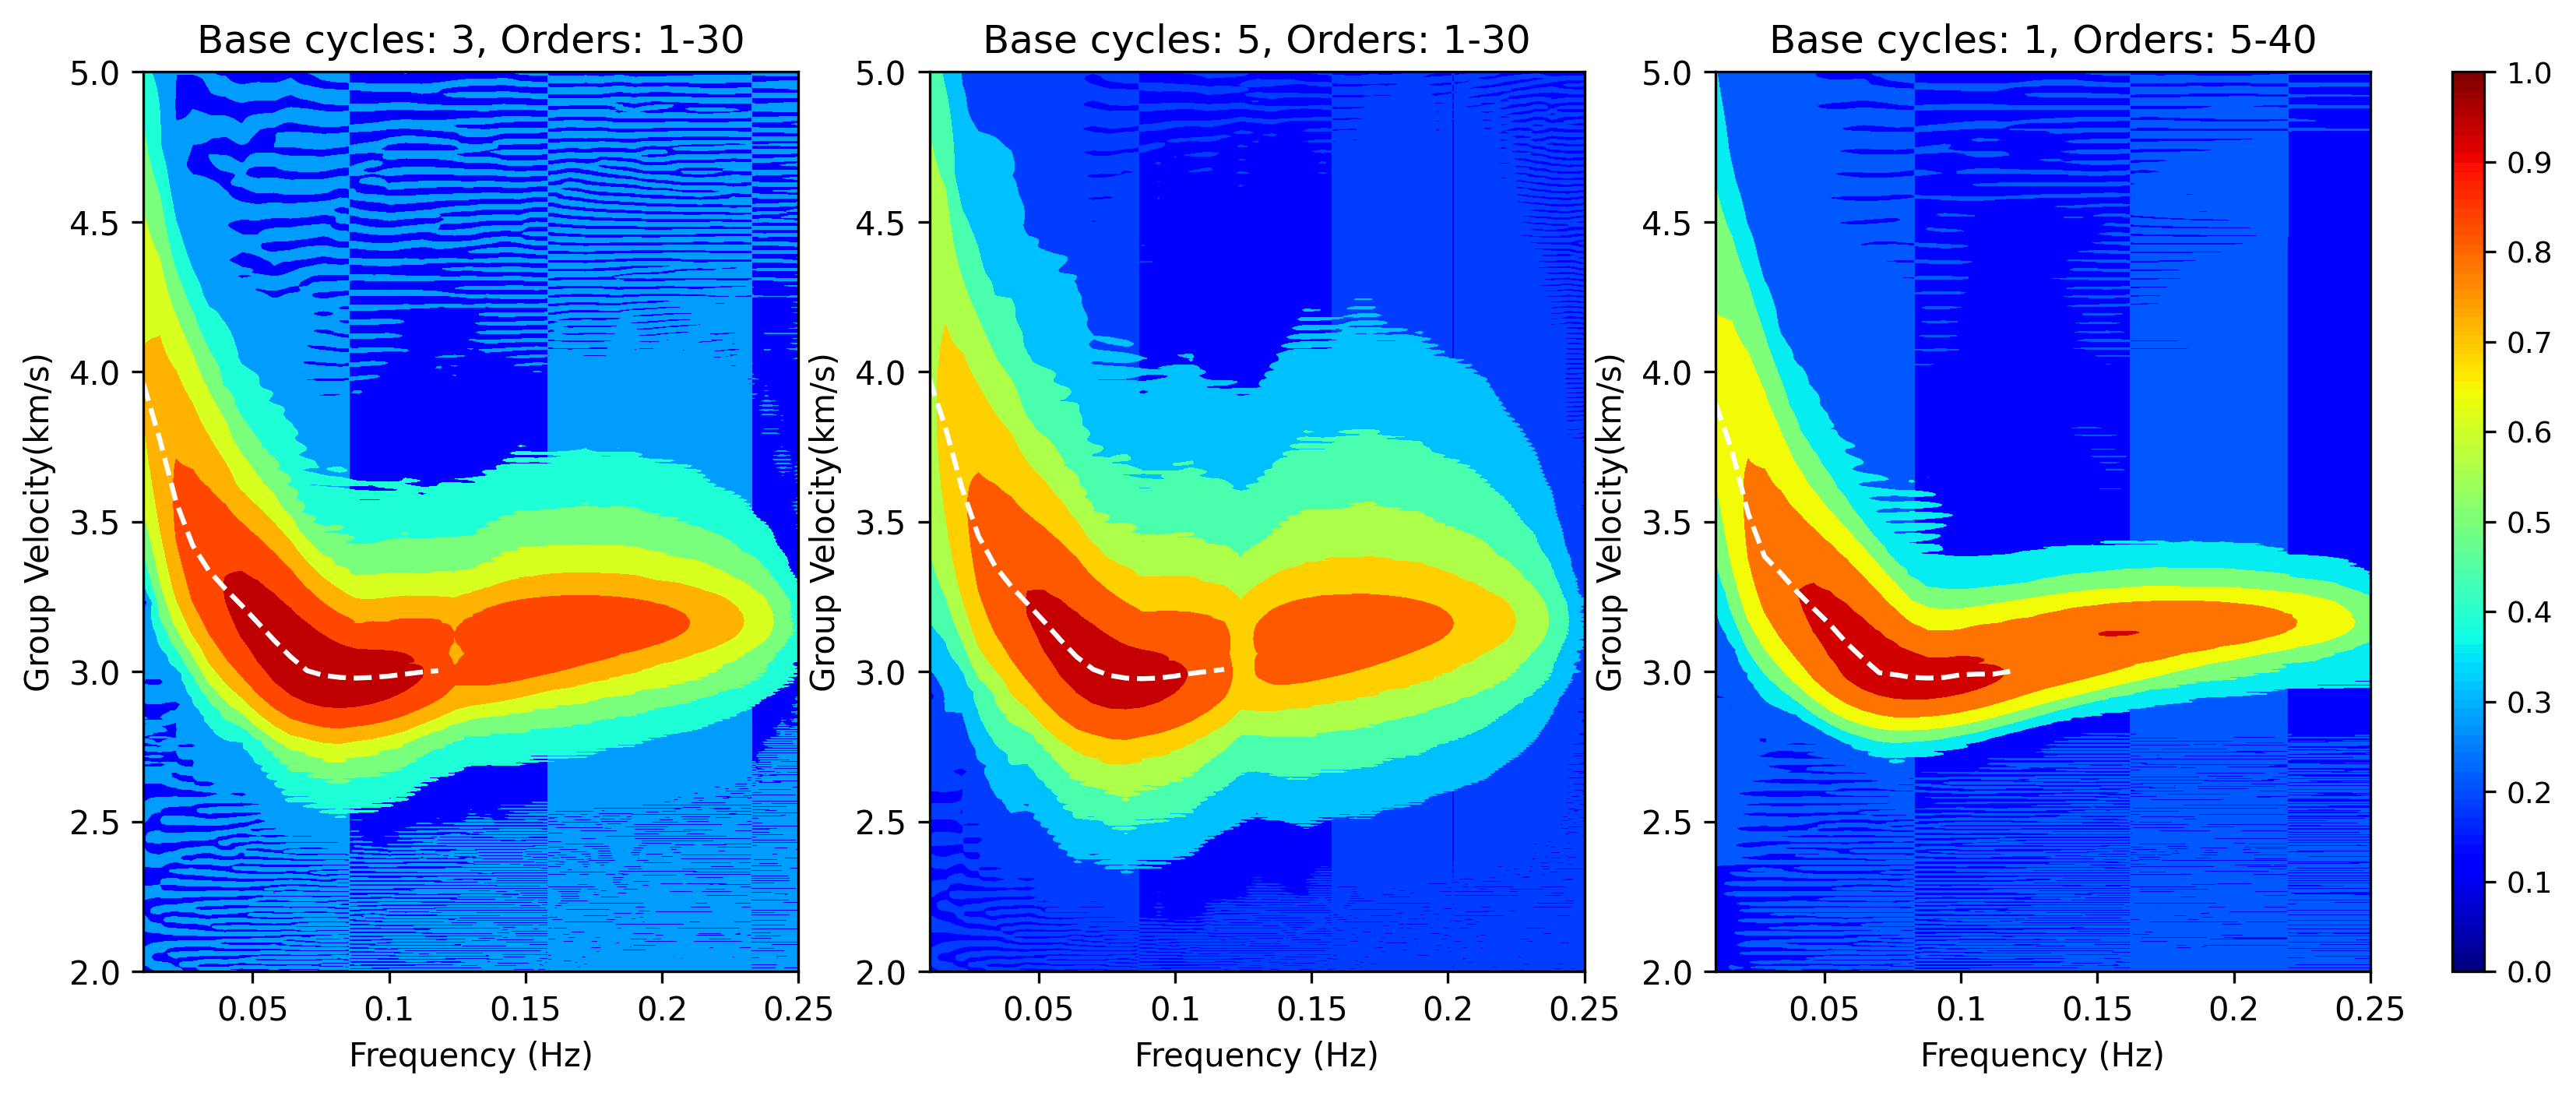

In [10]:
velocity=np.zeros(len(signal))
fig, ax = plt.subplots(ncols=3, figsize=(15, 5), dpi=300)
freqs = jnp.linspace(10, 250, 41)
for k in range(len(signal), 0, -1):
    velocity[len(signal)-k-1]=(distance)/k
# np.set_printoptions(threshold=sys.maxsize)

for (i, (base_cycle, min_order, max_order)) in enumerate(zip([3, 5, 1], [1, 1, 5], [30, 30, 40])):
    scalogram = adaptive_superlet_transform(signal, freqs, sampling_freq=fs*1000, 
                                        base_cycle=base_cycle, min_order=min_order, max_order=max_order, mode="mul")
    arr=[]
    points=np.zeros(len(freqs))
    for n in range (0,len(freqs)):
        amplitude=20*(np.log10(np.abs(scalogram[n])))
        points[n]=points[n]+np.argmax(np.abs(scalogram[n]))
    vg=distance/points
    ax[i].plot(freqs[:19], vg[:19], 'w--')
    ax[i].contourf(freqs, velocity, ((jnp.log10(jnp.abs(scalogram))).T)[::-1], cmap="jet", origin="lower")
    ax[i].set_title(f"Base cycles: {base_cycle}, Orders: {min_order}-{max_order}")
    ax[i].set_xlabel("Frequency (Hz)")
    ax[i].set_ylabel("Group Velocity(km/s)")
    ax[i].set_ylim(2, 5) 
    ax[i].set_xticks([50, 100, 150, 200, 250], [0.05, 0.10, 0.15, 0.20, 0.25]) 
m = plt.cm.ScalarMappable(cmap='jet')
m.set_array(jnp.log10(jnp.abs(scalogram)))
m.set_clim(0, 1.0)
myticks = np.arange(0, 1, 10)
cbar=plt.colorbar(m, ax=ax.ravel().tolist(), boundaries=np.linspace(0, 1, 100), ticks=[0, .1, .2, .3, .4,.5,.6,.7,.8,.9, 1],pad=.03, aspect=28)
cbar.ax.tick_params(labelsize=9, direction='out')
plt.show()